In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from utils.data_loader import CrashDataLoader 
import geopy.distance as geo_distance
from darts import TimeSeries
from darts.models import ExponentialSmoothing

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [108]:
plt.rcParams['figure.figsize'] = [12, 4]

In [3]:
data_loader = CrashDataLoader()

Loading data from: 
./data/2000 to 2005 ACCIDENT
./data/ACCIDENT


In [4]:
# Load per person accident data
person_df = data_loader.load_file("PERSON.csv")
person_df["inj_level"] = pd.to_numeric(person_df["inj_level"], errors="coerce")
person_df = person_df.dropna(subset=["inj_level"])
person_df["inj_level"] = person_df["inj_level"].astype('int32')

C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (0,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]
C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (6,9,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


In [5]:
# join nearest hospital_distance 
hospital_distance_df = pd.read_csv("./data/NodeHospitalDistance.csv")
injury_df = person_df[["accident_no","inj_level"]].groupby(by=["accident_no"]).min()

C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]
C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


Dropped 64 duplicate rows


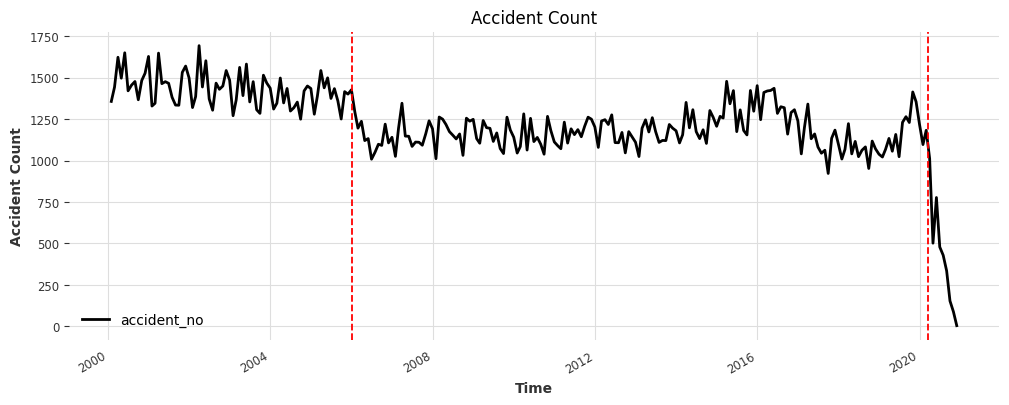

In [109]:
# Plot time - original accident_count 
# Preprocess accident df
accident_df = data_loader.load_file("ACCIDENT.csv")
accident_df = accident_df.fillna({"accidenttime":"00.00.00"})	
time_format = "%d/%m/%Y_%H:%M:%S"
accident_df["accident_datetime"] = pd.DatetimeIndex(
    pd.to_datetime((accident_df["accidentdate"]+"_"+accident_df["accidenttime"]).str.replace(".", ":").str.strip(),
                   format = time_format))
accident_df = accident_df.set_index("accident_datetime", drop=True)
accident_df = accident_df.sort_values(by = ["accident_datetime", "accident_no"])

# Drop duplicate
org_row_count = len(accident_df)
accident_df = accident_df.drop_duplicates(subset=['accidentdate', 'accidenttime', 'node_id'], keep="last")
print("Dropped {} duplicate rows".format(org_row_count - len(accident_df)))

injury_year_df = accident_df["accident_no"].groupby(pd.Grouper(freq='M')).count()
yearly_injury_ts = TimeSeries.from_series(injury_year_df)
yearly_injury_ts.plot()
plt.title("Accident Count")
plt.xlabel("Time")
plt.ylabel("Accident Count")
plt.axvline(pd.Timestamp('2006-01-01'), color='r', linestyle='--')
plt.axvline(pd.Timestamp('2020-03-16'), color='r', linestyle='--')
plt.show()

In [7]:
# Preprocess accident df
accident_df = data_loader.load_file("ACCIDENT.csv")
accident_df = accident_df.fillna({"accidenttime":"00.00.00"})	
time_format = "%d/%m/%Y_%H:%M:%S"
accident_df["accident_datetime"] = pd.DatetimeIndex(
    pd.to_datetime((accident_df["accidentdate"]+"_"+accident_df["accidenttime"]).str.replace(".", ":").str.strip(),
                   format = time_format))
accident_df = accident_df.set_index("accident_datetime", drop=True)
accident_df = accident_df.sort_values(by = ["accident_datetime", "accident_no"])

# Drop duplicate
org_row_count = len(accident_df)
accident_df = accident_df.drop_duplicates(subset=['accidentdate', 'accidenttime', 'node_id'], keep="last")
print("Dropped {} duplicate rows".format(org_row_count - len(accident_df)))

# Add injury level, keep those that only caused serious injury
accident_df = accident_df.join(injury_df["inj_level"], on = "accident_no")
accident_df = accident_df[accident_df["inj_level"].isin([1,2])]
accident_df = accident_df[accident_df.index < pd.Timestamp("2020-01-01")]
accident_df

C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]
C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


Dropped 64 duplicate rows


,accident_no,accidentdate,accidenttime,accident_type,accident type desc,day_of_week,day week description,dca_code,dca description,directory,...,no_persons_inj_2,no_persons_inj_3,no_persons_killed,no_persons_not_inj,police_attend,road_geometry,road geometry desc,severity,speed_zone,inj_level
accident_datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:30:00,12000002917,1/01/2000,00.30.00,2,Struck Pedestrian,7,Saturday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIG...,MEL,...,1,0,0,1,1,2,T intersection,2,60,2.0
2000-01-01 01:20:00,32000001167,1/01/2000,01.20.00,2,Struck Pedestrian,7,Saturday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT ...,MEL,...,0,3,1,1,1,5,Not at intersection,1,60,1.0
2000-01-01 04:57:00,12000002642,1/01/2000,04.57.00,4,Collision with a fixed object,7,Saturday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICL...,MEL,...,1,0,0,0,1,5,Not at intersection,2,60,2.0
2000-01-01 05:45:00,52000027299,1/01/2000,05.45.00,6,Vehicle overturned (no collision),7,Saturday,174,OUT OF CONTROL ON CARRIAGEWAY (ON STRAIGHT) ...,MEL,...,1,0,0,1,2,5,Not at intersection,2,100,2.0
2000-01-01 05:50:00,32000002671,1/01/2000,05.50.00,4,Collision with a fixed object,7,Saturday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICL...,MEL,...,1,0,0,0,1,2,T intersection,2,60,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 06:00:00,T20190026518,31/12/2019,06:00:00,4,Collision with a fixed object,2,Tuesday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICL...,VCD,...,1,0,0,0,1,5,Not at intersection,2,100,2.0
2019-12-31 10:29:00,T20190026546,31/12/2019,10:29:00,1,Collision with vehicle,3,Tuesday,110,CROSS TRAFFIC(INTERSECTIONS ONLY),MEL,...,0,3,1,0,1,1,Cross intersection,1,80,1.0
2019-12-31 11:40:00,T20190026550,31/12/2019,11:40:00,2,Struck Pedestrian,3,Tuesday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIG...,MEL,...,0,1,0,1,1,5,Not at intersection,2,60,2.0


In [10]:
injury_year_df = accident_df[accident_df.index < pd.Timestamp("2020-01-01")]["accident_no"].groupby(pd.Grouper(freq='Y')).count()
fatality_year_df = accident_df[(accident_df.index < pd.Timestamp("2020-01-01")) & (accident_df["inj_level"]==1)]["accident_no"].groupby(pd.Grouper(freq='Y')).count()

<Axes: xlabel='accident_datetime'>

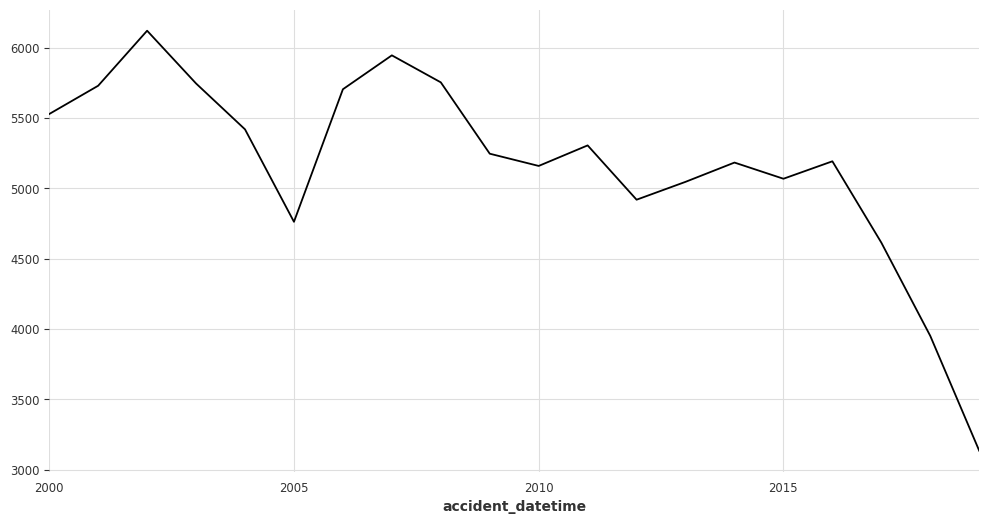

In [11]:
injury_year_df.plot()

In [66]:
# Create a TimeSeries, specifying the time and value columns
yearly_injury_ts = TimeSeries.from_series(injury_year_df)
yearly_fatality_ts = TimeSeries.from_series(fatality_year_df)
model = ExponentialSmoothing(seasonal=None, damped=True)
model.fit(yearly_injury_ts)
prediction = model.predict(10, num_samples=100)

In [67]:
# model_2 = ExponentialSmoothing(smoothing_level=0.8, smoothing_trend=0.1, seasonal=None, damped=True)
# model_2.fit(yearly_injury_ts)
# prediction_2 = model_2.predict(10, num_samples=10)

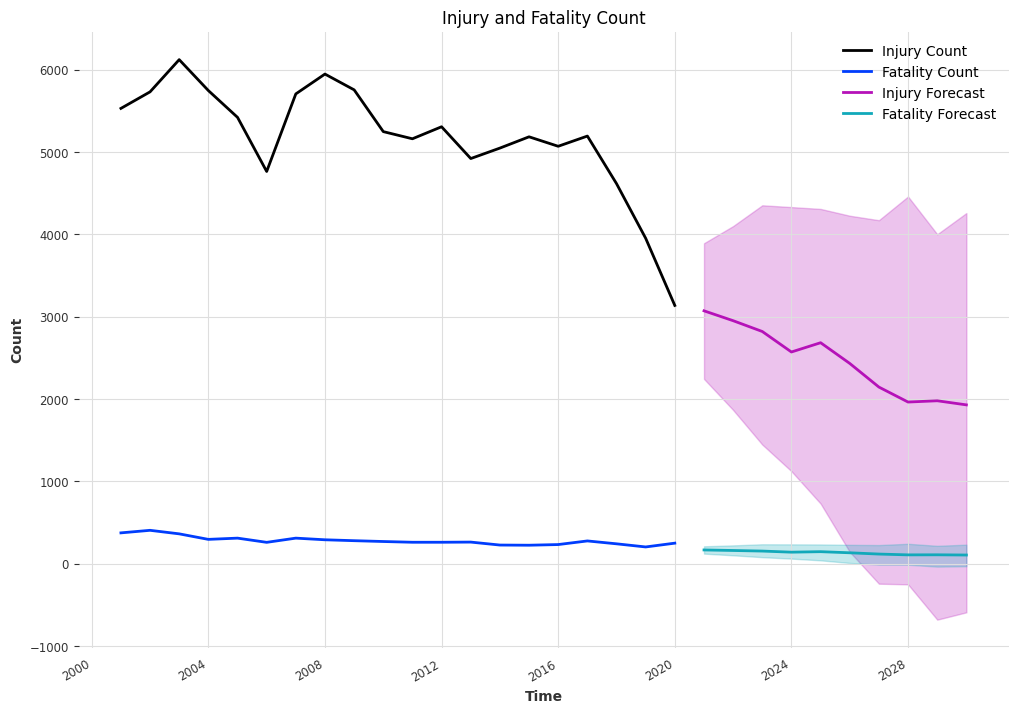

In [77]:
# Plot forecast
# https://otexts.com/fpp2/ets-forecasting.html#ets-forecasting
yearly_injury_ts.plot(label="Injury Count")
yearly_fatality_ts.plot(label="Fatality Count")
prediction.plot(label="Injury Forecast", low_quantile=0.05, high_quantile=0.95)
(prediction*0.053911).plot(label="Fatality Forecast", low_quantile=0.05, high_quantile=0.95)
# prediction_2.plot(label="forecast_2", low_quantile=0.05, high_quantile=0.95)

plt.title("Injury and Fatality Count")
plt.xlabel("Time")
plt.ylabel("Count")
plt.legend()

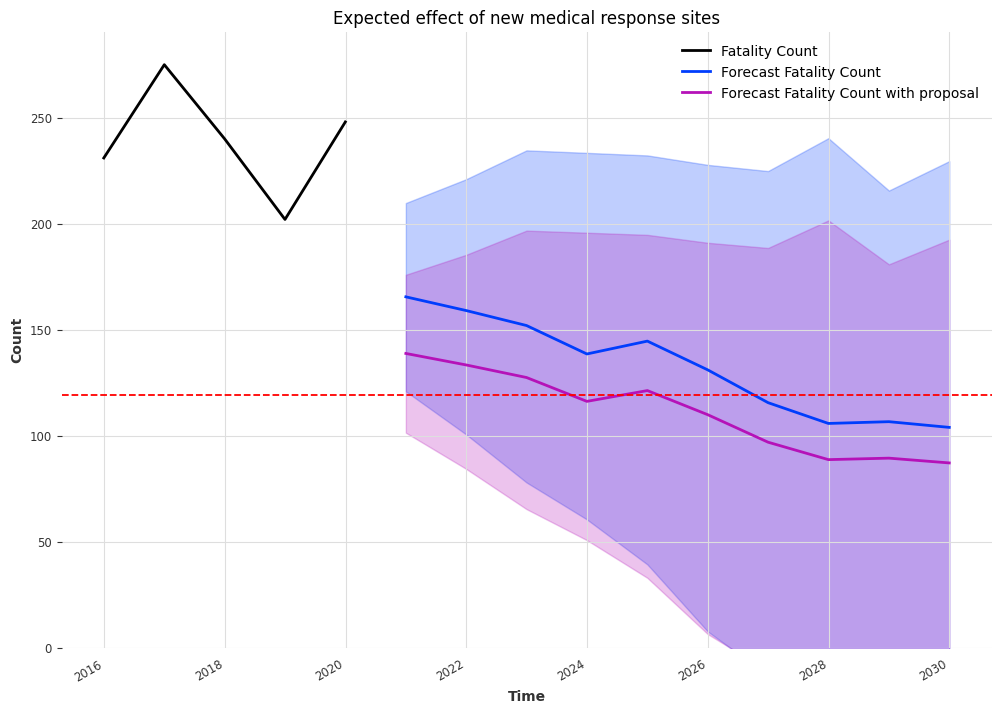

In [78]:
target_2030_fatality_count = int(yearly_fatality_ts[-5:].mean(axis=0).first_value()/2)

yearly_fatality_ts[-5:].plot(label="Fatality Count")
(prediction*0.053911).plot(label="Forecast Fatality Count", low_quantile=0.05, high_quantile=0.95)
(prediction*0.045211).plot(label="Forecast Fatality Count with proposal", low_quantile=0.05, high_quantile=0.95)
plt.axhline(target_2030_fatality_count, color='r', linestyle='--')
plt.title("Expected effect of new medical response sites")
plt.ylim(bottom=0)
plt.xlabel("Time")
plt.ylabel("Count")
plt.legend()

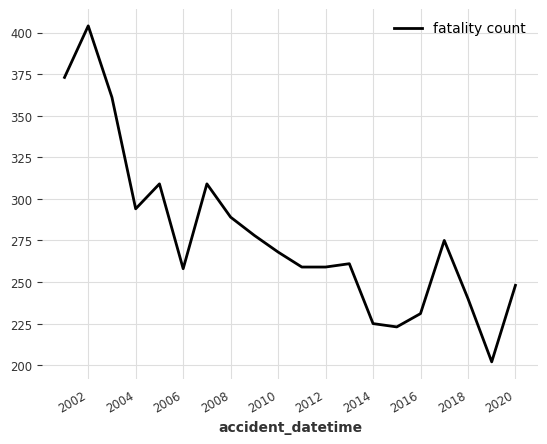

In [62]:
yearly_fatality_ts.plot(label="fatality count")
plt.legend()

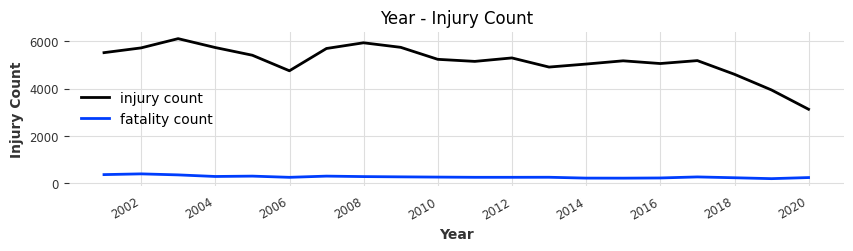

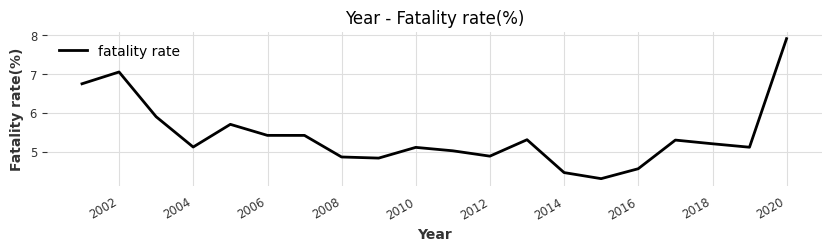

In [144]:
yearly_injury_ts.plot(label="injury count")
yearly_fatality_ts.plot(label="fatality count")
plt.title("Year - Injury Count")
plt.xlabel("Year")
plt.ylabel("Injury Count")
plt.show()

(yearly_fatality_ts/yearly_injury_ts*100).plot(label="fatality rate")
plt.title("Year - Fatality rate(%)")
plt.xlabel("Year")
plt.ylabel("Fatality rate(%)")
plt.show()
# plt.legend()

In [61]:
# accident_df["accident_no"].groupby(pd.Grouper(freq='M')).count().plot()
# plt.axvline(pd.Timestamp('2005-12-31 23:25:00'), color='r', linestyle='--')
# plt.axvline(pd.Timestamp('2020-03-16'), color='r', linestyle='--')

In [68]:
hospital_distance_df

,node_id,hospital_id,hospital_distance
0,2,3483,14.639399
1,3,10582,10.513244
2,4,3392,4.628801
3,5,10214,4.951063
4,6,3424,2.011056
...,...,...,...
192751,666001,3292,0.576044
192752,666018,11269,24.015182
192753,666033,3405,5.792985
192754,666054,3390,5.662858


In [82]:
#
accident_to_hospital_df = accident_df.join(hospital_distance_df.set_index("node_id"), on = "node_id")[["accident_no","inj_level","node_id","hospital_id","hospital_distance"]]
accident_to_hospital_df

,accident_no,inj_level,node_id,hospital_id,hospital_distance
accident_datetime,,,,,
2000-01-01 00:30:00,12000002917,2.0,240,3395.0,1.016114
2000-01-01 01:20:00,32000001167,1.0,126463,10214.0,9.109861
2000-01-01 04:57:00,12000002642,2.0,127371,3395.0,1.844091
2000-01-01 05:45:00,52000027299,2.0,129631,3466.0,15.869264
2000-01-01 05:50:00,32000002671,2.0,45854,10214.0,8.866009
...,...,...,...,...,...
2019-12-31 06:00:00,T20190026518,2.0,633571,6739.0,49.588579
2019-12-31 10:29:00,T20190026546,1.0,45326,10441.0,11.399648
2019-12-31 11:40:00,T20190026550,2.0,614732,11607.0,6.995910


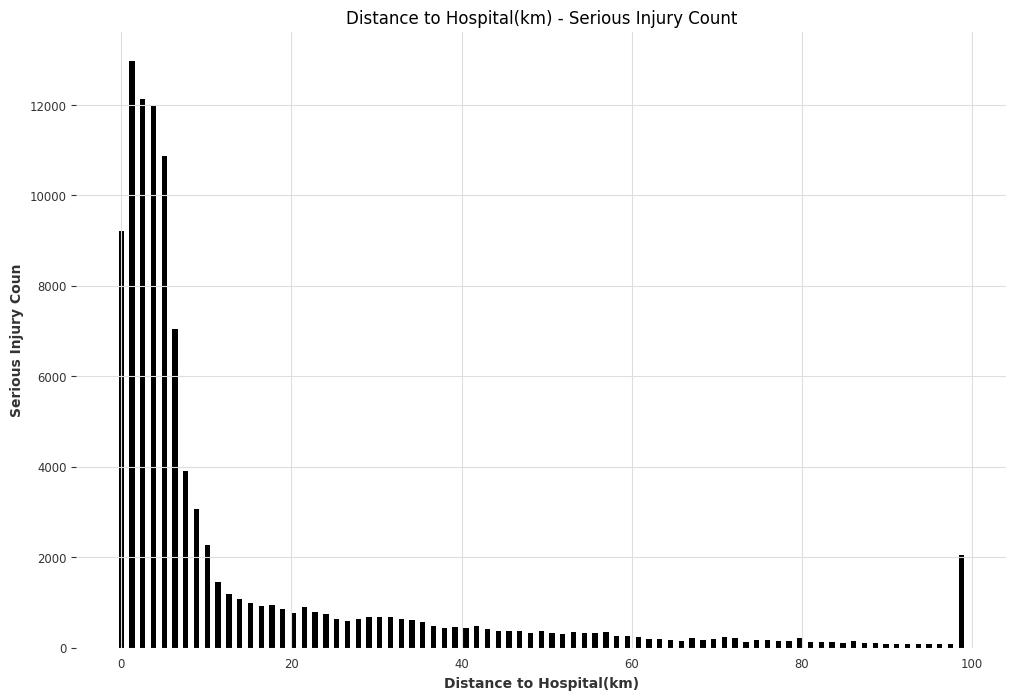

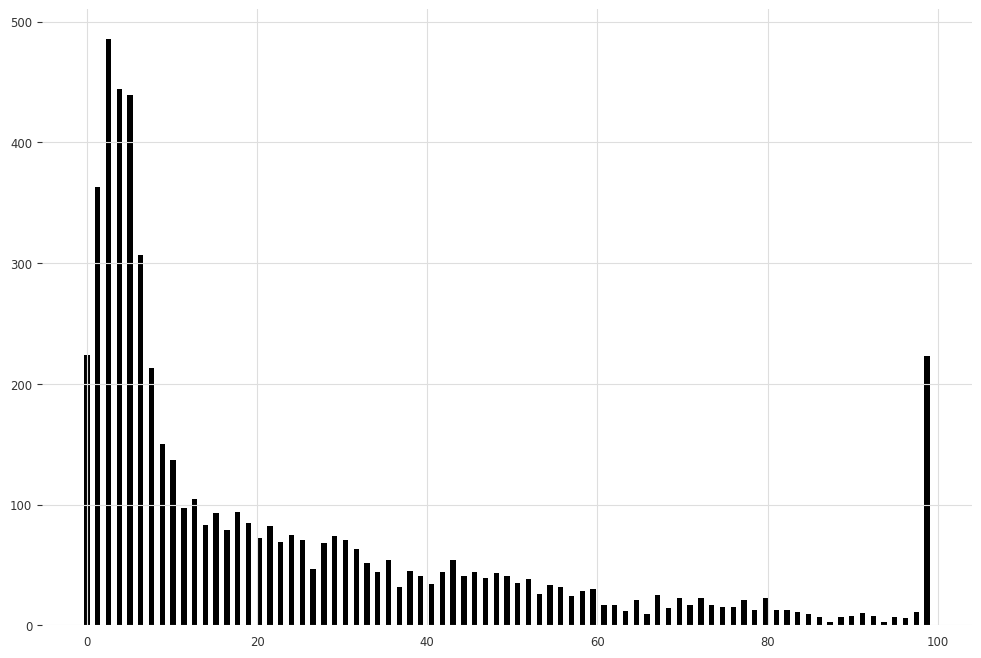

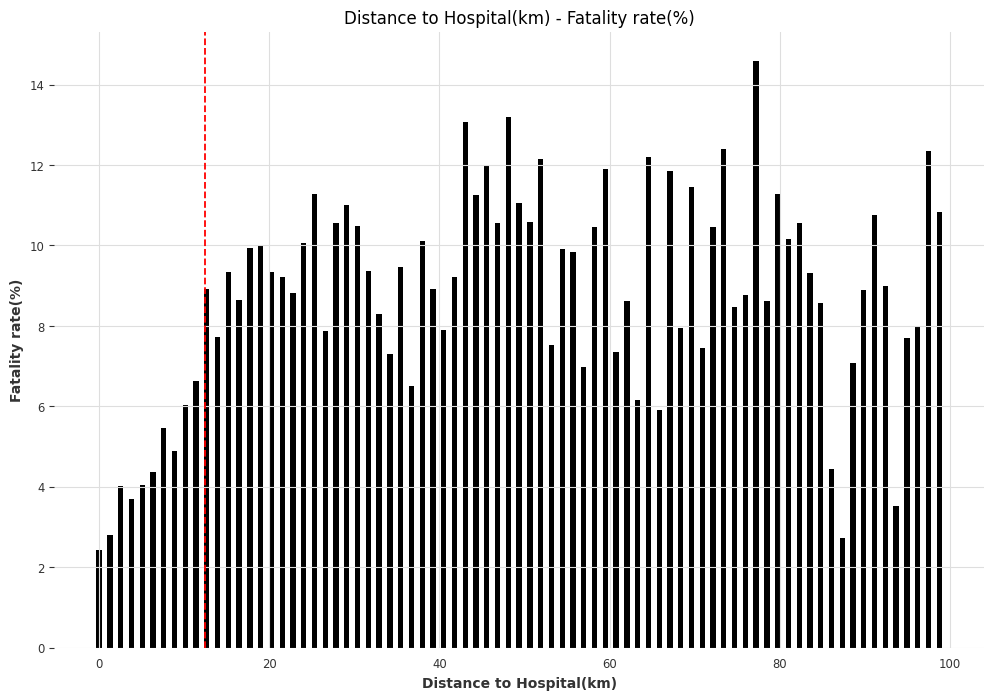

5566.0


In [87]:
distance_range = (0,100)
bin_count = 80
bins = np.linspace(*distance_range, bin_count)
bins[-1] = 50000

_df = accident_to_hospital_df

width = (distance_range[1]-distance_range[0])/bin_count/2
death_count, bins = np.histogram(_df[_df["inj_level"]==1]["hospital_distance"], bins=bins)
inj_count, _ = np.histogram(_df[_df["inj_level"].isin([1,2])]["hospital_distance"], bins=bins)
plt.bar(bins[:-1],inj_count,width=width)
plt.title("Distance to Hospital(km) - Serious Injury Count")
plt.xlabel("Distance to Hospital(km)")
plt.ylabel("Serious Injury Coun")
plt.show()
plt.bar(bins[:-1],death_count,width=width)
plt.show()
plt.bar(bins[:-1],death_count/inj_count*100,width=width)
# .plot.density(color='k', alpha=0.5, ax=ax) 
# plt.xticks(bins[:-1], rotation=70)
plt.axvline(12.5, color='r', linestyle='--')
plt.title("Distance to Hospital(km) - Fatality rate(%)")
plt.xlabel("Distance to Hospital(km)")
plt.ylabel("Fatality rate(%)")
plt.show()

org_fatality_rate_np = death_count/inj_count

print(sum(inj_count* org_fatality_rate_np))

In [88]:
# Load new hospital distance
rec_hospital_distance_df = pd.read_csv("./data/HospitalRecommendation/NodeHospitalDistance_kmeans_50.csv")
rec_accident_to_hospital_df = accident_df.join(rec_hospital_distance_df.set_index("node_id"), on = "node_id")[["accident_no","inj_level","node_id","hospital_id","hospital_distance"]]
rec_accident_to_hospital_df

,accident_no,inj_level,node_id,hospital_id,hospital_distance
accident_datetime,,,,,
2000-01-01 00:30:00,12000002917,2.0,240,3395.0,1.016114
2000-01-01 01:20:00,32000001167,1.0,126463,10214.0,9.109861
2000-01-01 04:57:00,12000002642,2.0,127371,3395.0,1.844091
2000-01-01 05:45:00,52000027299,2.0,129631,3466.0,15.869264
2000-01-01 05:50:00,32000002671,2.0,45854,10214.0,8.866009
...,...,...,...,...,...
2019-12-31 06:00:00,T20190026518,2.0,633571,-39.0,30.480904
2019-12-31 10:29:00,T20190026546,1.0,45326,10441.0,11.399648
2019-12-31 11:40:00,T20190026550,2.0,614732,11607.0,6.995910


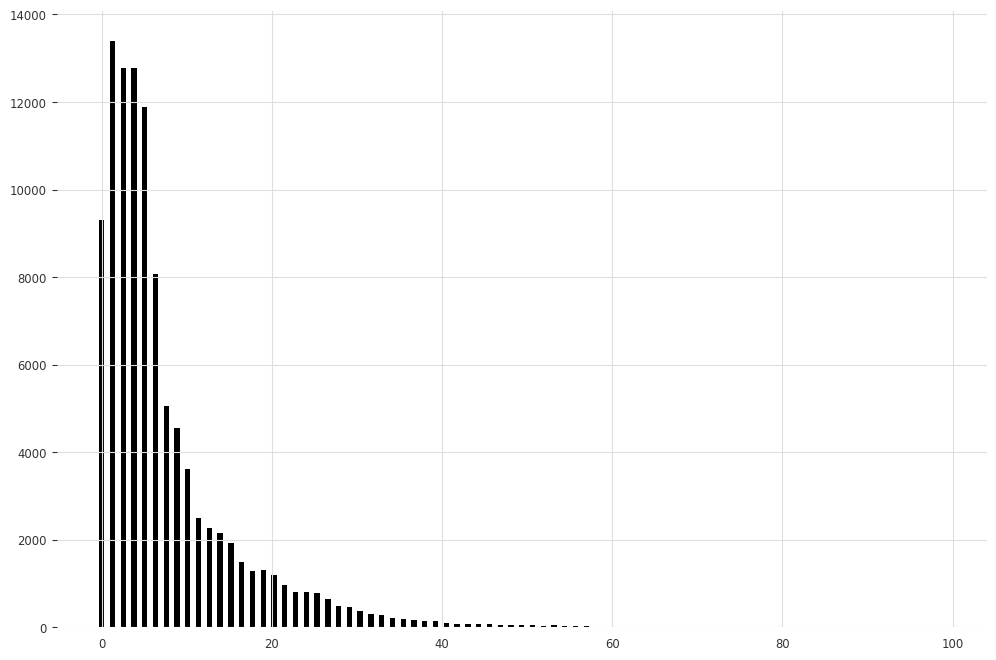

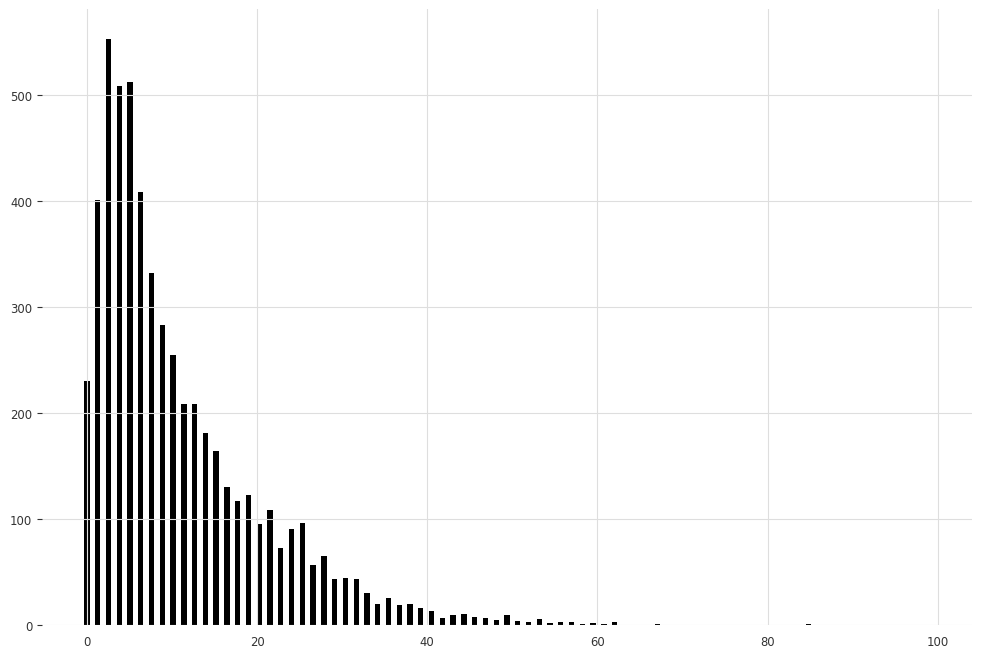

C:\Users\HanHsin\AppData\Local\Temp\ipykernel_10028\2893183717.py:15: RuntimeWarning: invalid value encountered in divide
  plt.bar(bins[:-1],death_count/inj_count,width=width)


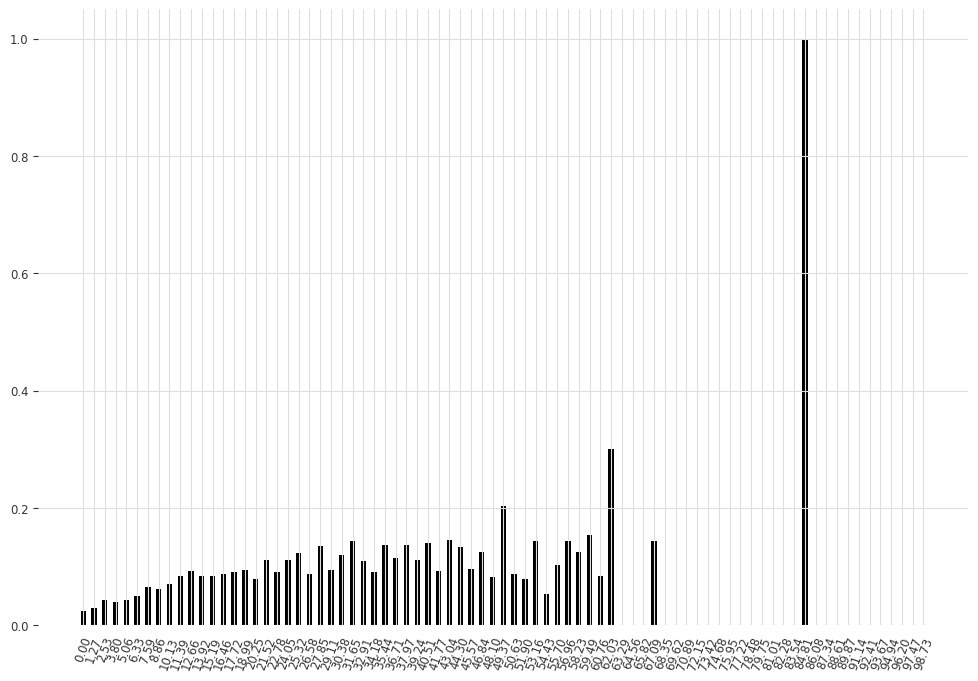

5088.041645916107


In [89]:
distance_range = (0,100)
bin_count = 80
bins = np.linspace(*distance_range, bin_count)
bins[-1] = 50000

_df = rec_accident_to_hospital_df

width = (distance_range[1]-distance_range[0])/bin_count/2
death_count, bins = np.histogram(_df[_df["inj_level"]==1]["hospital_distance"], bins=bins)
inj_count, _ = np.histogram(_df[_df["inj_level"].isin([1,2])]["hospital_distance"], bins=bins)
plt.bar(bins[:-1],inj_count,width=width)
plt.show()
plt.bar(bins[:-1],death_count,width=width)
plt.show()
plt.bar(bins[:-1],death_count/inj_count,width=width)
# .plot.density(color='k', alpha=0.5, ax=ax) 
plt.xticks(bins[:-1], rotation=70)
plt.show()

print(sum(inj_count* org_fatality_rate_np))

In [90]:
1-5088/5566.0

0.08587854832914121

In [91]:
# Generate fatality reducement
rec_fatality_list = []
for n_recommendations in [1,2,3,4,5,6,7,8,9,10,20,30,40,50,100]:
    rec_hospital_distance_df = pd.read_csv("./data/HospitalRecommendation/NodeHospitalDistance_kmeans_{}.csv".format(n_recommendations))
    rec_accident_to_hospital_df = accident_df.join(rec_hospital_distance_df.set_index("node_id"), on = "node_id")[["accident_no","inj_level","node_id","hospital_id","hospital_distance"]]

    distance_range = (0,100)
    bin_count = 80
    bins = np.linspace(*distance_range, bin_count)
    bins[-1] = 50000
    
    _df = rec_accident_to_hospital_df
    
    width = (distance_range[1]-distance_range[0])/bin_count/2
    death_count, bins = np.histogram(_df[_df["inj_level"]==1]["hospital_distance"], bins=bins)
    inj_count, _ = np.histogram(_df[_df["inj_level"].isin([1,2])]["hospital_distance"], bins=bins)
    # plt.bar(bins[:-1],inj_count,width=width)
    # plt.show()
    # plt.bar(bins[:-1],death_count,width=width)
    # plt.show()
    # plt.bar(bins[:-1],death_count/inj_count,width=width)
    # # .plot.density(color='k', alpha=0.5, ax=ax) 
    # plt.xticks(bins[:-1], rotation=70)
    # plt.show()

    new_fatality_count = sum(inj_count* org_fatality_rate_np)
    rec_fatality_list.append({
        "n_recommendations":n_recommendations,
        "org_fatality_count": sum(death_count),
        "org_fatality_rate": sum(death_count)/sum(inj_count),
        "fatality_count":sum(inj_count* org_fatality_rate_np),
        "fatality_rate":sum(inj_count* org_fatality_rate_np)/sum(inj_count),
        "fatality_rate_improvement": 1-(sum(inj_count* org_fatality_rate_np)/sum(inj_count))/(sum(death_count)/sum(inj_count))
    })

rec_fatality_df = pd.DataFrame(rec_fatality_list)
rec_fatality_df

,n_recommendations,org_fatality_count,org_fatality_rate,fatality_count,fatality_rate,fatality_rate_improvement
0,1,5566,0.053911,5546.368984,0.053721,0.003527
1,2,5566,0.053911,5557.825541,0.053832,0.001469
2,3,5566,0.053911,5541.185654,0.053671,0.004458
3,4,5566,0.053911,5548.106998,0.053738,0.003215
4,5,5566,0.053911,5520.070840,0.053466,0.008252
5,6,5566,0.053911,5539.286593,0.053652,0.004799
6,7,5566,0.053911,5519.505341,0.053461,0.008353
7,8,5566,0.053911,5503.825085,0.053309,0.011170
8,9,5566,0.053911,5485.541965,0.053132,0.014455
9,10,5566,0.053911,5487.353513,0.053149,0.014130


Text(0, 0.5, 'Distance to Hospital(km)')

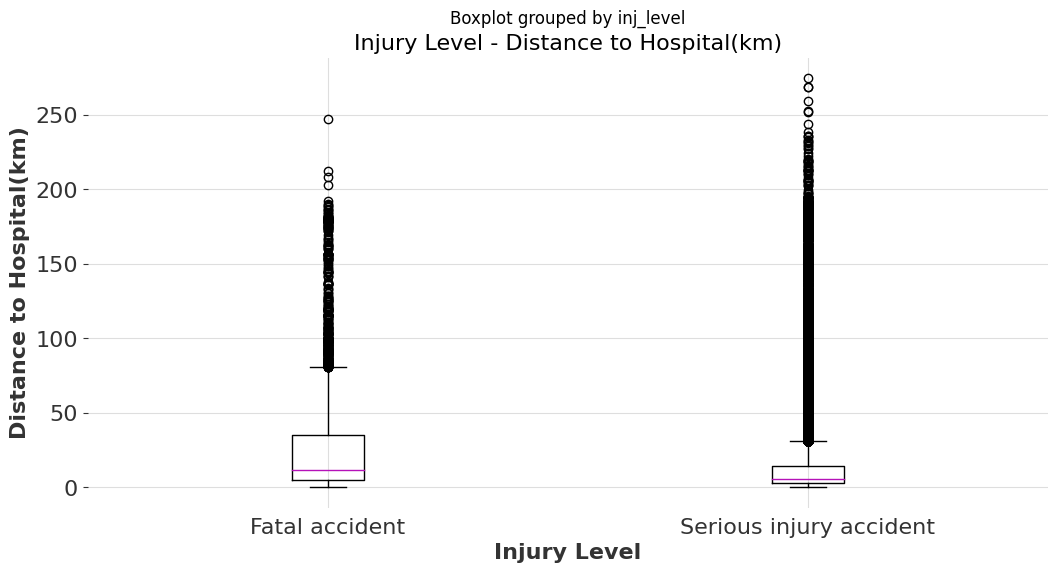

In [125]:
ax = accident_to_hospital_df.boxplot(column=["hospital_distance"], by=["inj_level"], fontsize=16)
ax.set_xticklabels(["Fatal accident","Serious injury accident"])
ax.set_title("Injury Level - Distance to Hospital(km)", fontsize=16)
ax.set_xlabel("Injury Level", fontsize=16)
ax.set_ylabel("Distance to Hospital(km)", fontsize=16)

<Axes: title={'center': 'hospital_distance'}, xlabel='[inj_level]'>

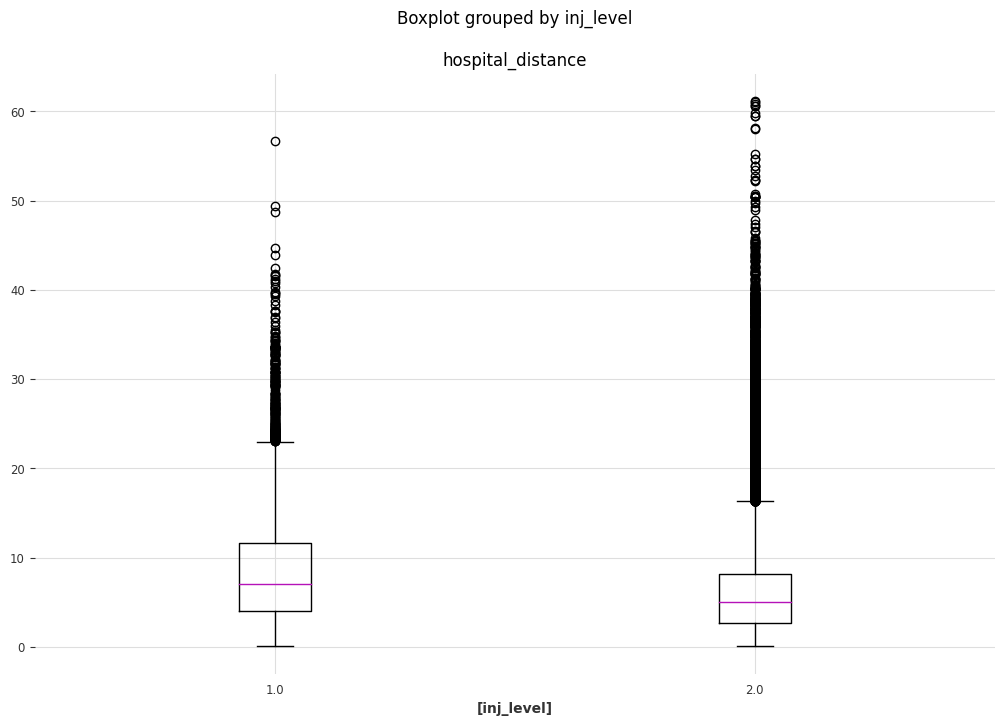

In [92]:
rec_accident_to_hospital_df.boxplot(column=["hospital_distance"], by=["inj_level"])

In [94]:
rec_accident_to_hospital_df

,accident_no,inj_level,node_id,hospital_id,hospital_distance
accident_datetime,,,,,
2000-01-01 00:30:00,12000002917,2.0,240,3395.0,1.016114
2000-01-01 01:20:00,32000001167,1.0,126463,10214.0,9.109861
2000-01-01 04:57:00,12000002642,2.0,127371,3395.0,1.844091
2000-01-01 05:45:00,52000027299,2.0,129631,3466.0,15.869264
2000-01-01 05:50:00,32000002671,2.0,45854,10214.0,8.866009
...,...,...,...,...,...
2019-12-31 06:00:00,T20190026518,2.0,633571,-56.0,22.182982
2019-12-31 10:29:00,T20190026546,1.0,45326,10441.0,11.399648
2019-12-31 11:40:00,T20190026550,2.0,614732,11607.0,6.995910


In [95]:
accident_to_hospital_df

,accident_no,inj_level,node_id,hospital_id,hospital_distance
accident_datetime,,,,,
2000-01-01 00:30:00,12000002917,2.0,240,3395.0,1.016114
2000-01-01 01:20:00,32000001167,1.0,126463,10214.0,9.109861
2000-01-01 04:57:00,12000002642,2.0,127371,3395.0,1.844091
2000-01-01 05:45:00,52000027299,2.0,129631,3466.0,15.869264
2000-01-01 05:50:00,32000002671,2.0,45854,10214.0,8.866009
...,...,...,...,...,...
2019-12-31 06:00:00,T20190026518,2.0,633571,6739.0,49.588579
2019-12-31 10:29:00,T20190026546,1.0,45326,10441.0,11.399648
2019-12-31 11:40:00,T20190026550,2.0,614732,11607.0,6.995910


Text(0, 0.5, 'Distance to Hospital(km)')

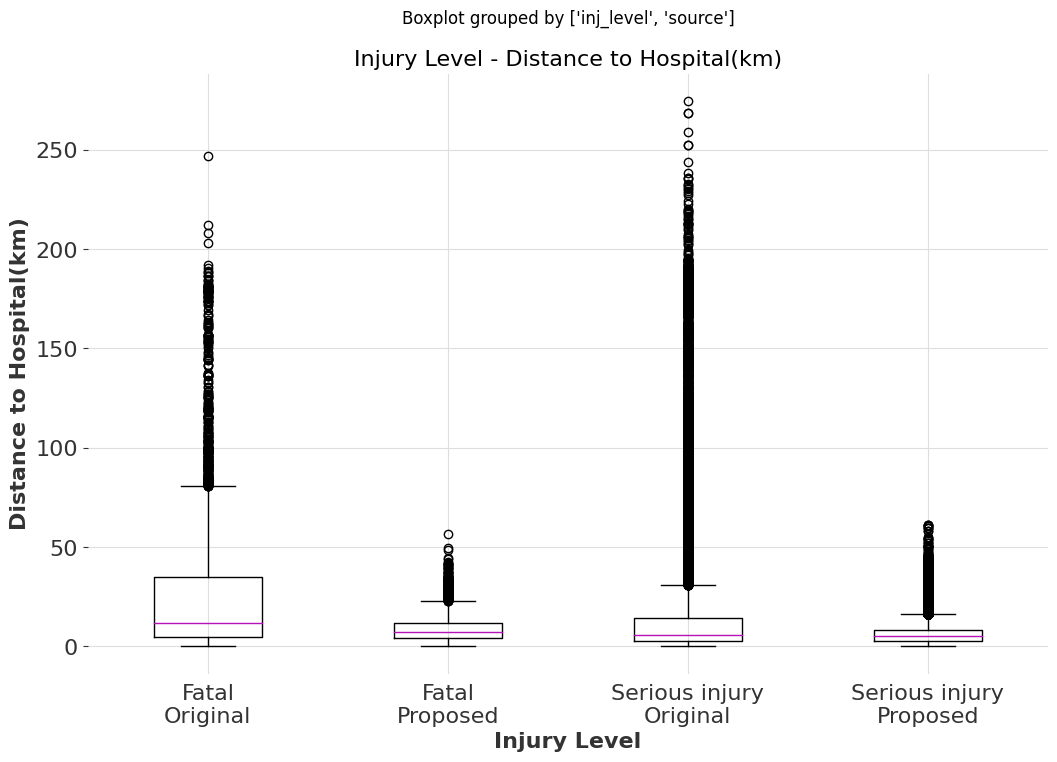

In [104]:
_df1 = accident_to_hospital_df
_df1["source"] = "org"
_df2 = rec_accident_to_hospital_df
_df2["source"] = "rec"

ax = pd.concat([rec_accident_to_hospital_df,accident_to_hospital_df]).boxplot(column=["hospital_distance"], by=["inj_level","source"], fontsize=16)
ax.set_xticklabels(["Fatal\nOriginal","Fatal\nProposed","Serious injury\nOriginal","Serious injury\nProposed"])
ax.set_title("Injury Level - Distance to Hospital(km)", fontsize=16)
ax.set_xlabel("Injury Level", fontsize=16)
ax.set_ylabel("Distance to Hospital(km)", fontsize=16)